지금까지 운송 경로(운송 비용 최적화)와 생산 계획 최적화 문제를 따로 다뤘습니다. 그렇지만 실제 물류 네트워크는 이 둘을 동시에 고려해야 합니다.

물류 네트워크)            
         
대리점 P,Q : 제품 판매                 
상품군 A,B : 제품 > 예측된 수요량이 존재          
공장 X,Y : 수요량을 근거로 생산량 결정            
생산 라인 0,1 : 공장의 레인 0, 1                              

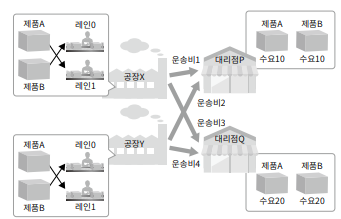

이런 물류 네트워크를 최적화하려면 어떻게 정식화하는 것이 좋을까?        
상품의 수요가 이미 결정되어 있다면(수요를 촉진하는 광고나 선전을 하지 않는다면) 가장 중요한 것은 <U>어떻게 비용을 낮출 것인가</U>하는 것입니다.          
즉, 운송 비용과 제조 비용이 수요를 만족하면서 최소가 되게 정식화합니다.            
<U><B>목적함수는 운송 비용과 제조 비용의 합으로 정의하고, 제약 조건은 각 대리점의 판매 수가 수요 수를 넘는 것으로 정의합니다.</U></B>          
여기서는 라이브러리 ortoolpy의 함수 logistics_network를 이용해서 최적 설계를 진행합니다.

In [20]:
import numpy as np
import pandas as pd

제품 = list('AB')
수요지 = list('PQ')
공장 = list('XY')
레인 = (2,2) # 공장 X : 레인 2개, 공장 Y : 레인 2개

# 수요
trans_demand = pd.DataFrame(((j, k) for j in  수요지 for k in 제품), columns= ['수요지', '제품'])
trans_demand['수요'] = [10, 10, 20, 20]
print(trans_demand)
print()

# 운송비 
trans_price = pd.DataFrame(((j, k) for j in 수요지 for k in 공장), columns= ['수요지', '공장'])
trans_price['운송비'] = [1,2,3,1]
print(trans_price)
print()

# 생산
# for fac, lane in zip(공장, 레인) : # X, 2 > Y, 2
#   print(fac, lane)

trans_fac = pd.DataFrame(((fac, l, p, 0, np.inf) for fac, lane in zip(공장, 레인) for l in range(lane) for p in 제품), columns= ['공장', '레인', '제품', '하한', '상한'])
trans_fac['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
trans_fac.dropna(axis= 0, how= 'any', inplace= True)
trans_fac
trans_fac.loc[4, '상한'] = 10 # index : 4, column : '상한'
trans_fac

  수요지 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20

  수요지 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1



,공장,레인,제품,하한,상한,생산비
0,X,0,A,0,inf,1.0
3,X,1,B,0,inf,1.0
4,Y,0,A,0,10.0,3.0
6,Y,1,A,0,inf,5.0
7,Y,1,B,0,inf,3.0


logistics_network(demand, pridce, factory)              
demand > 수요 데이터로 ['수요지', '제품', '수요']              
price > 운송비 데이터로 ['공장', '수요지', '운송비']                 
factory > 생산 가능 데이터로 ['공장', '제품', '하한', '상한', '생산비']                   
해당 열들을 반드시 포함해야 함

In [ ]:
from ortoolpy import logistics_network

# var1 : 최적화 성공 여부
# var2 : trans_ship(운송계획표) - 공장 > 수요지로 얼마나 보낼지에 대한 운송량
# var3 : trans_make(생산계획표) - 공장에서 얼마나 생산할지에 대한 생산량
var1, var2, var3 = logistics_network(trans_demand, trans_price, trans_fac, 
                                        dep= '수요지', dem= '수요', fac= '공장', prd= '제품', tcs = '운송비',  pcs = '생산비',
                                        lwb = '하한', upb = '상한')
# print(var1) # True
# print(var2) # ['수요지', '공장', '운송비', '제품', 'VarX', 'ValX']
# print(var3) # ['공장', '레인', '제품', '하한', '상한', '생산비', 'VarY', 'ValY']

# trans_make에 ValY라는 항목이 만들어지면서 최적 생산량이 저장되고
# 운송비 표에 ValX라는 항목이 만들어지고 최적 운송량이 저장됩니다.

In [ ]:
# trans_shipment : 운송량 df
# trans_make == trans_fac : 최적 생산량 df
_, trans_shipment, trans_make = logistics_network(trans_demand, trans_price, trans_fac, 
                                        dep= '수요지', dem= '수요', fac= '공장', prd= '제품', tcs = '운송비',  pcs = '생산비',
                                        lwb = '하한', upb = '상한')

trans_shipment

,수요지,공장,운송비,제품,VarX,ValX
0,P,X,1,A,v000079,10.0
1,P,X,1,B,v000080,10.0
2,P,Y,2,A,v000081,0.0
3,P,Y,2,B,v000082,0.0
4,Q,X,3,A,v000083,10.0
5,Q,X,3,B,v000084,0.0
6,Q,Y,1,A,v000085,10.0
7,Q,Y,1,B,v000086,20.0


>> 운송 비용 계산

In [ ]:
# trans_shipment 데이터프레임 > 운송 비용 = '운송비' * ValX(최적 운송량)

trans_shipment = trans_shipment[['공장', '수요지', '운송비', '제품', 'VarX', 'ValX']]
trans_shipment
trans_shipment.columns = ['공장', '대리점', '운송비', '제품', 'VarX', 'ValX']
trans_shipment

trans_cost = 0
for i in range(len(trans_shipment.index)) :
  trans_cost += trans_shipment['운송비'].iloc[i] * trans_shipment['ValX'].iloc[i]
print('총 운송 비용 : ', trans_cost)

# 총 운송 비용은 80만원으로
# 내역을 확인해보면 운송비가 적은 공장 X > 대리점 P, 공장 Y > 대리점 Q의 경로를 사용하고
# 이것만으로는 대리점 Q에 의한 상품 A의 수요가 부족하기 때문에(A 20, B 20으로 A제품 10이 부족)
# 공장 X에서 대리점 Q로 상품 A를 10만큼 운송합니다.
# 공장 Y의 생산(레인0)에는 한계가 있고 생산표에 의하면 공장 X의 제품 A 생산 비용이 다른 곳보다 낮기 때문에(Y 레인 0, 1)
# 이 조합은 대체로 타당하다고 생각해도 될 것 같습니다.

총 운송 비용 :  80.0


In [33]:
# trans_fac == trans_make
trans_fac

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000087,20.0
3,X,1,B,0,inf,1.0,v000088,10.0
4,Y,0,A,0,10.0,3.0,v000089,10.0
6,Y,1,A,0,inf,5.0,v000090,0.0
7,Y,1,B,0,inf,3.0,v000091,20.0
